# Unsupervised surgery pipeline with TRVAE

In [1]:
import os
os.chdir('../')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
import scanpy as sc
import torch
import scarches as sca
from scarches.dataset.trvae.data_handling import remove_sparsity
import matplotlib.pyplot as plt
import numpy as np
import gdown
import pandas as pd

 captum (see https://github.com/pytorch/captum).
INFO:lightning_fabric.utilities.seed:Global seed set to 0
/root/anaconda3/envs/multigrate/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)
os.environ['CUDA_VISIBLE_DEVICES']='1'

### Set relevant anndata.obs labels and training length

Here we use the CelSeq2 and SS2 studies as query data and the other 3 studies as reference atlas. We strongly suggest to use earlystopping to avoid over-fitting. The best earlystopping criteria is the 'val_unweighted_loss' for TRVAE.

In [10]:
rna = []
adt = []
for i in range(1,9):
    adt.append(sc.AnnData(pd.read_csv('./data/processed/wnn_p%d_cellmask/subset_0/mat/adt.csv'%i, index_col=0).values))
    rna.append(sc.AnnData(pd.read_csv('./data/processed/wnn_p%d_cellmask/subset_0/mat/rna.csv'%i, index_col=0).values))

In [11]:
for i in range(8):
    rna[i].obs[['batch']] = i
    adt[i].obs[['batch']] = i

In [12]:
rna = sc.concat(rna)
adt = sc.concat(adt)

In [13]:
condition_key = 'batch'
# cell_type_key = 'l1'
target_conditions = [i for i in range(1, 8)]


trvae_epochs = 500
surgery_epochs = 500

early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss",
    "threshold": 0,
    "patience": 20,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}

### Download Dataset and split into reference dataset and query dataset

In [5]:
adata_all = sc.read_h5ad('./data/raw/rna+adt/wnn/rna_new.h5ad')
adt = sc.read_h5ad('./data/raw/rna+adt/wnn/adt_new.h5ad')

In [16]:
# rna_count = pd.DataFrame(adata_all.X.todense(), index=adata_all.obs_names, columns=adata_all.var_names)
# print(rna_count.shape)
# adt_count = pd.DataFrame(adt.X.todense(), index=adt.obs_names, columns=adt.var_names)
# print(adt_count.shape)
multi = np.concatenate([rna.X, adt.X], axis=1)
print(multi.shape)

(46213, 4261)


In [18]:
adata_all = sc.AnnData(X=multi, obs=rna.obs)

In [19]:
adata_all.obs['batch'] = adata_all.obs['batch'].astype('category')

This line makes sure that count data is in the adata.X. Remember that count data in adata.X is necessary when using "nb" or "zinb" loss. However, when using trVAE with MSE loss normalized data is necessary in adata.X

In [20]:
adata = adata_all
adata = remove_sparsity(adata)
source_adata = adata[~adata.obs[condition_key].isin(target_conditions)]
target_adata = adata[adata.obs[condition_key].isin(target_conditions)]
source_conditions = source_adata.obs[condition_key].unique().tolist()

In [23]:
source_adata

View of AnnData object with n_obs × n_vars = 6142 × 4261
    obs: 'batch'

In [11]:
target_adata

View of AnnData object with n_obs × n_vars = 46586 × 3841
    obs: 'orig.ident', 'nCount_rna', 'nFeature_rna', 'nCount_adt', 'nFeature_adt', 'l1', 'batch'

### Create TRVAE model and train it on reference dataset

Create the trVAE model instance with NB loss as default. Insert "recon_loss='mse'," or "recon_loss='zinb'," to change the reconstruction loss.

In [24]:
trvae = sca.models.TRVAE(
    adata=source_adata,
    condition_key=condition_key,
    conditions=source_conditions,
    hidden_layer_sizes=[128, 128],
    latent_dim=32
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 4261 128 1
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 32
Decoder Architecture:
	First Layer in, out and cond:  32 128 1
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 4261 



In [25]:
trvae.train(
    n_epochs=trvae_epochs,
    alpha_epoch_anneal=200,
    early_stopping_kwargs=early_stopping_kwargs
)

 |██████--------------| 32.0%  - val_loss: 2364.5792480469 - val_recon_loss: 2354.1080566406 - val_kl_loss: 13.1713697433 - val_mmd_loss: 0.0000000000
ADJUSTED LR
 |███████-------------| 37.2%  - val_loss: 2360.6830566406 - val_recon_loss: 2348.7762695312 - val_kl_loss: 12.8722673416 - val_mmd_loss: 0.0000000000
ADJUSTED LR
 |████████------------| 41.0%  - val_loss: 2359.9655761719 - val_recon_loss: 2347.2656250000 - val_kl_loss: 12.6999488831 - val_mmd_loss: 0.0000000000
ADJUSTED LR
 |████████------------| 42.4%  - val_loss: 2361.1563476563 - val_recon_loss: 2348.4536132812 - val_kl_loss: 12.7027193069 - val_mmd_loss: 0.0000000000
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 190


After pretraining the model can be saved for later use

In [42]:
ref_path = './result/wnn_cellmask/trvae+scarches/default/train_0'
trvae.save(ref_path, overwrite=True)

In [33]:
if not os.path.exists('./result/wnn_cellmask/trvae+scarches/default/predict/subset_0'):
    os.makedirs('./result/wnn_cellmask/trvae+scarches/default/predict/subset_0')
    pd.DataFrame(trvae.get_latent()).to_csv('./result/wnn_cellmask/trvae+scarches/default/predict/subset_0/00.csv', index=False, header=False)

### Perform surgery on reference model and train on query dataset

In [44]:
for i in range(1,8):
    target_adata = adata[adata.obs['batch']==i]
    print(target_adata)
    new_trvae = sca.models.TRVAE.load_query_data(adata=target_adata, reference_model=ref_path)
    new_trvae.train(
        n_epochs=surgery_epochs,
        alpha_epoch_anneal=200,
        early_stopping_kwargs=early_stopping_kwargs,
        weight_decay=0
    )
    ref_path = './result/wnn_cellmask/trvae+scarches/default/train_%d'%i
    new_trvae.save(ref_path, overwrite=True)
    if not os.path.exists('./result/wnn_cellmask/trvae+scarches/default/predict/subset_%d/z/joint/'%i):
        os.makedirs('./result/wnn_cellmask/trvae+scarches/default/predict/subset_%dz/joint/'%i)
    pd.DataFrame(new_trvae.get_latent()).to_csv('./result/wnn_cellmask/trvae+scarches/default/predict/subset_%d/z/joint/00.csv'%i, index=False, header=False)

View of AnnData object with n_obs × n_vars = 3978 × 4261
    obs: 'batch'
View of AnnData object with n_obs × n_vars = 3978 × 4261
    obs: 'batch'

INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 4261 128 2
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 32
Decoder Architecture:
	First Layer in, out and cond:  32 128 2
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 4261 

 |█████---------------| 25.2%  - val_loss: 3153.4226074219 - val_recon_loss: 3138.8449707031 - val_kl_loss: 23.3242731094 - val_mmd_loss: 0.0000000000
ADJUSTED LR
 |█████---------------| 28.2%  - val_loss: 3182.0930175781 - val_recon_loss: 3165.6820678711 - val_kl_loss: 23.4441924095 - val_mmd_loss: 0.0000000000
ADJUSTED LR
 |██████--------------| 32.2%  - val_loss: 3156.3725585938 - val_recon_loss: 3137.6655883789 - val_kl_loss: 23.3836584091 - val_mmd_loss: 0.0000000000
ADJUSTED LR
 |██████--------------| 33.6%  - val_loss: 3126.9600830078 - val_re

In [18]:
new_trvae = sca.models.TRVAE.load_query_data(adata=target_adata, reference_model=ref_path)

View of AnnData object with n_obs × n_vars = 46586 × 3841
    obs: 'orig.ident', 'nCount_rna', 'nFeature_rna', 'nCount_adt', 'nFeature_adt', 'l1', 'batch'

INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 3841 128 8
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 32
Decoder Architecture:
	First Layer in, out and cond:  32 128 8
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 3841 



In [19]:
new_trvae.train(
    n_epochs=surgery_epochs,
    alpha_epoch_anneal=200,
    early_stopping_kwargs=early_stopping_kwargs,
    weight_decay=0
)

 |--------------------| 1.6%  - val_loss: 2402.5053710938 - val_recon_loss: 2366.8514239337 - val_kl_loss: 15.4563288560 - val_mmd_loss: 35.1130019523

In [ ]:
adata_latent = sc.AnnData(new_trvae.get_latent())
adata_latent.obs['cell_type'] = target_adata.obs[cell_type_key].tolist()
adata_latent.obs['batch'] = target_adata.obs[condition_key].tolist()
adata_latent.obs['batch'] = adata_latent.obs['batch'].astype('category')

In [ ]:
surg_path = './comparison/results/wnn/trave_online'
new_trvae.save(surg_path, overwrite=True)

### Get latent representation of reference + query dataset and compute UMAP

In [ ]:
full_latent = sc.AnnData(new_trvae.get_latent(adata.X, adata.obs[condition_key]))
full_latent.obs['cell_type'] = adata.obs[cell_type_key].tolist()
full_latent.obs['batch'] = adata.obs[condition_key].tolist()
full_latent.obs['batch'] = full_latent.obs['batch'].astype('category')

In [ ]:
pd.DataFrame(full_latent.X, index=adata.obs_names).to_csv('./comparison/results/wnn/trave_online/embeddings.csv')

# Offline

In [ ]:
os.makedirs('./comparison/results/wnn/trave_offline/')

In [ ]:
source_conditions = [0,1,2,3,4,5,6,7]

In [ ]:
trvae = sca.models.TRVAE(
    adata=adata_all,
    condition_key=condition_key,
    conditions=source_conditions,
    hidden_layer_sizes=[128, 128],
    latent_dim=32
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 3841 128 8
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 32
Decoder Architecture:
	First Layer in, out and cond:  32 128 8
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 3841 



In [ ]:
trvae.train(
    n_epochs=trvae_epochs,
    alpha_epoch_anneal=200,
    early_stopping_kwargs=early_stopping_kwargs
)

 |████----------------| 21.6%  - val_loss: 2282.5629069010 - val_recon_loss: 2227.2650785900 - val_kl_loss: 29.2514853250 - val_mmd_loss: 39.6482908158
ADJUSTED LR
 |█████---------------| 29.2%  - val_loss: 2281.3393554688 - val_recon_loss: 2224.1851690383 - val_kl_loss: 22.3529001872 - val_mmd_loss: 40.9483364650
ADJUSTED LR
 |██████--------------| 34.8%  - val_loss: 2286.8968331473 - val_recon_loss: 2225.1896333240 - val_kl_loss: 19.5169593720 - val_mmd_loss: 44.8250190190
ADJUSTED LR
 |███████-------------| 36.2%  - val_loss: 2287.6476818266 - val_recon_loss: 2226.2753324963 - val_kl_loss: 19.2698518662 - val_mmd_loss: 44.0294799805
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 159


In [ ]:
full_latent = sc.AnnData(trvae.get_latent(adata_all.X, adata_all.obs[condition_key]))
full_latent.obs['cell_type'] = adata_all.obs[cell_type_key].tolist()
full_latent.obs['batch'] = adata_all.obs[condition_key].tolist()
full_latent.obs['batch'] = full_latent.obs['batch'].astype('category')

... storing 'cell_type' as categorical


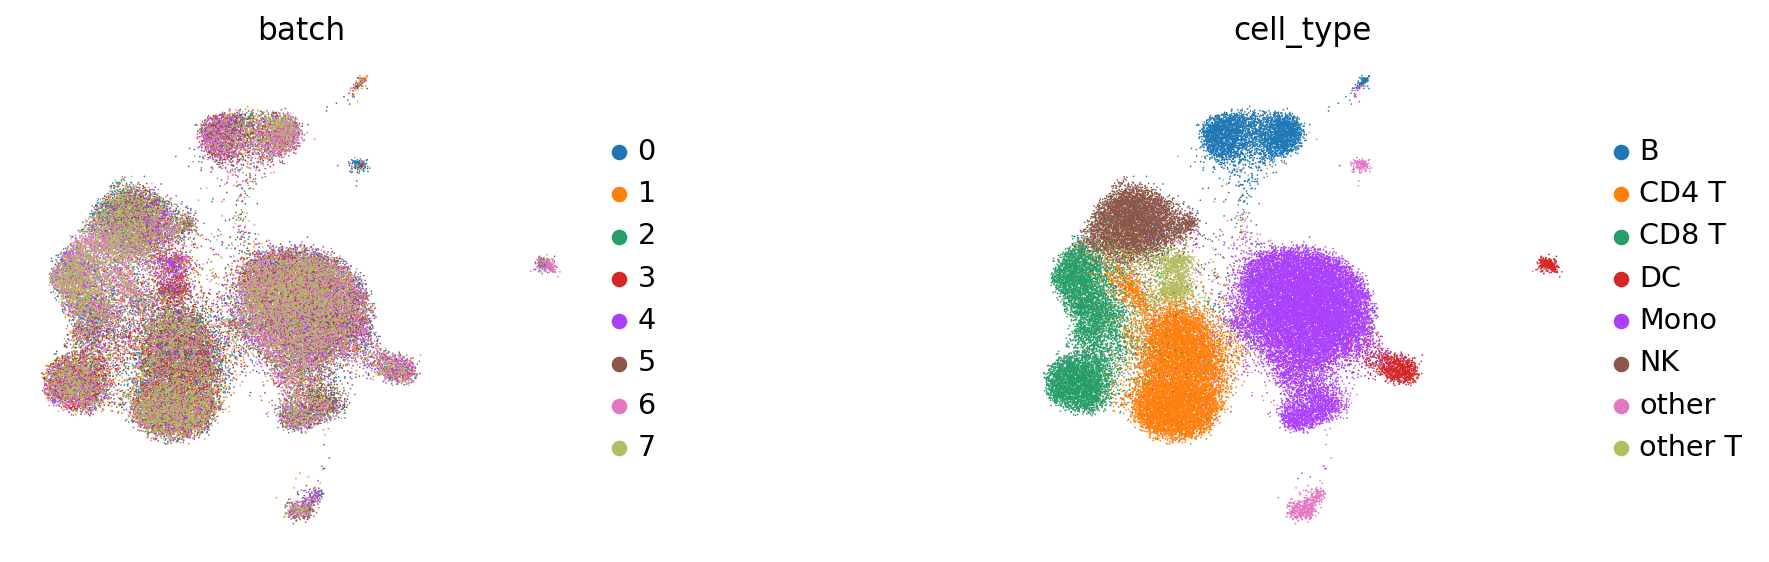

In [18]:
sc.pp.neighbors(full_latent, n_neighbors=8)
# sc.tl.leiden(full_latent)
sc.tl.umap(full_latent)
sc.pl.umap(full_latent,
           color=['batch', 'cell_type'],
           frameon=False,
           wspace=0.6,
           show = False
        #    save='scarches_offline_trvae_rna+adt_all.png'
           )
plt.savefig('./comparison/results/wnn/trave_offline/figures/wnn_trvae_offline.png')

In [ ]:
pd.DataFrame(full_latent.X, index=adata.obs_names).to_csv('./comparison/results/wnn/trave_online/embeddings.csv')